## Анализ ответов клиентов на маркетинговое предложение банка


Перевозчиков Михаил Сергеевич

Данный проект нацелен на демонстрацию базовых навыков обработки датасета, построения модели машинного обучения и визуализации данных.

## Содержание

* [Часть 1. Описание проекта](#chapter1)
* [Часть 2. Очистка данных](#chapter2)
* [Часть 3. Обработка данных](#chapter3)
* [Часть 4. Построение модели](#chapter4)
* [Часть 5. Исследовательский анализ данных](#chapter5)
* [Часть 6. Рекомендации](#chapter6)



In [4]:
# Imported libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from tqdm import tqdm
import time
import statistics



# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier


# Imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline



/home/michael/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [3]:
# Display parameters 
pd.options.display.float_format = '{:.5f}'.format
from IPython.display import HTML

In [4]:

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Для упрощения чтения код данной страницы автоматически скрыт.
Чтобы посмотреть\скрыть код, нажмите <a href="javascript:code_toggle()">здесь</a>.''')

### 1) Описание проекта <a class='anchor' id='chapter1'></a>

В настоящее время маркетинг имеет огромную ценность для банковского сектора, что требует от банков повышать эффективность маркетинговой стратегии. Анализ потребностей клиентов приводит к оптимизации маркетинговой кампании, проработанному сервис-дизайну и, в конечном счете, к большей удовлетворенности клиентов.

#### Главной целью данного проекта является повышение эффективности маркетинговой кампании банка.
Анализ характеристик клиентов позволит разработать детальное понимание поведения различных групп клиентов, что поможет составить специфические рекомендации для каждой из этих групп. Главной задачей анализа является поиск групп клиентов, которые более склонны к тому чтобы согласиться на предлагаемую банком услугу -- открытие срочного вклада. 

### 2) Очистка данных <a class='anchor' id='chapter2'></a>

Набор данных создан на основе маркетинговой кампании, проведенная португальским банковским учреждением путём прямого телефонного обзвона клиентовб целью которой являлось продвижение услуги по открытию срочного вклада среди действующих клиентов. Данный датасет доступен по адресу http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [6]:
df = pd.read_csv('./bank-additional-full.csv', sep=';')

Удалим колонку со значением 'duration' (длительность коммуникации), поскольку данная характеристика неизвестна до начала взаимодействия с клиентом и не имеет предиктивной ценности.

In [328]:
df = df.drop(['duration'], axis=1)

In [329]:
df.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000
mean,40.02406,2.56759,962.47545,0.17296,0.08189,93.57566,-40.50260,3.62129,5167.03591
std,10.42125,2.77001,186.91091,0.49490,1.57096,0.57884,4.62820,1.73445,72.25153
min,17.00000,1.00000,0.00000,0.00000,-3.40000,92.20100,-50.80000,0.63400,4963.60000
25%,32.00000,1.00000,999.00000,0.00000,-1.80000,93.07500,-42.70000,1.34400,5099.10000
50%,38.00000,2.00000,999.00000,0.00000,1.10000,93.74900,-41.80000,4.85700,5191.00000
75%,47.00000,3.00000,999.00000,0.00000,1.40000,93.99400,-36.40000,4.96100,5228.10000
max,98.00000,56.00000,999.00000,7.00000,1.40000,94.76700,-26.90000,5.04500,5228.10000


Посмотрим, насколько наш датасет является несбалансированным

(Комментарий: в дальнейшем на графиках будут сравниваться клиенты, согласившиеся на предлагаемый банком срочный вклад - 'Yes' и клиенты, отказавшиеся от срочного вклада - 'No')

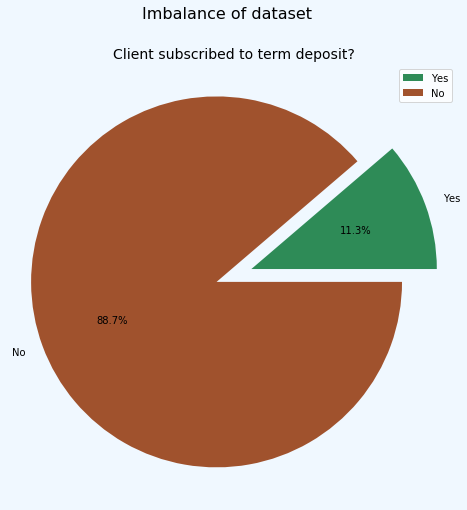

In [330]:
labels = ['Yes', 'No']
sizes = [len(df[df['y'] == 'yes'])/len(df)*100, len(df[df['y'] == 'no'])/len(df)*100]
explode = [0.2,0]

f, ax = plt.subplots(figsize=(8,8))
colors = {'Yes':'seagreen', 'No':'sienna'}
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', colors=[colors[t] for t in labels])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Client subscribed to term deposit?', fontsize=14)
f.set_facecolor('aliceblue')
f.suptitle('Imbalance of dataset', fontsize=16)
plt.legend()
plt.show()


In [331]:
# Create categorical and numerical columns lists
categorical_columns = []
numerical_columns = []
for col in df.columns:
    if df[col].dtype == 'O':
        categorical_columns.append(col)
    else:
        numerical_columns.append(col)

Проверим данные на выбросы и пропуски

In [332]:
df.dropna()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no


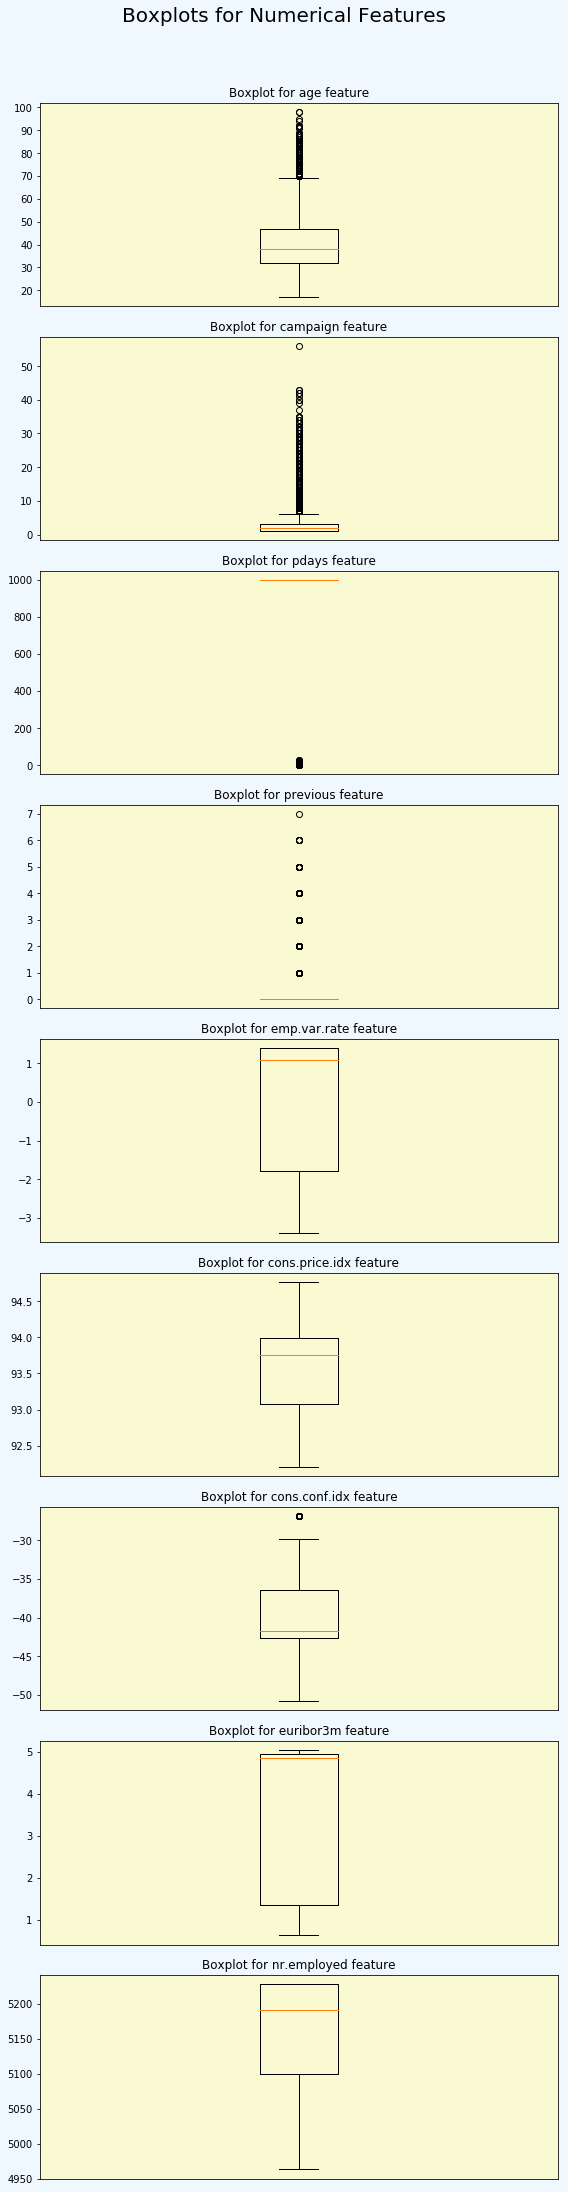

In [333]:
fig, axes = plt.subplots(len(numerical_columns), 1, figsize=(8,32))

count = 0
for ax in axes.flat:
    ax.set_title(f'Boxplot for {numerical_columns[count]} feature')
    ax.boxplot(df[numerical_columns[count]])
    ax.set_facecolor('lightgoldenrodyellow')
    ax.set_xticks([])
    count += 1

fig.set_facecolor('aliceblue')
fig.suptitle('Boxplots for Numerical Features', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust()
    

Поскольку датасет был предварительно обработан составителями, мы не наблюдаем большого количества выбросов или пропусков данных.

Удалим строки, где возраст клиента составляет менее 18 лет, поскольку в таком возрасте нельзя открыть срочный вклад без согласия законных представителей.

In [334]:
# 5 Rows deleted

df = df[df['age'] >= 18]

Пенсионный возраст в Португалии составляет 65 лет. Существуют профессии (военные, сотрудники сил правопорядка и т.д.) с сокращенным сроком выхода на пенсию, но не ранее 50 лет. Таким образом, мы можем исключить из датасета строки с клиентами, указанными как "пенсионеры", с возрастом менее 50 лет.

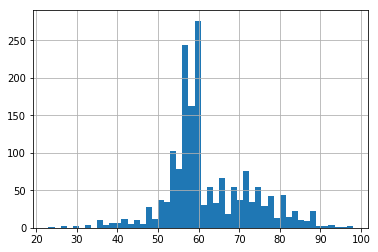

In [335]:
# Check for early retirement

df[df['job'] == 'retired'].age.hist(bins=50)

In [336]:
# 109 Samples deleted

df = df.drop(df[(df['job'] == 'retired') & (df['age'] < 50)].index, axis=0)


Обработаем "неизвестные" значения.

Только 3 клиента имеют частный дефолт в прошлом, поэтому данную характерстику можно удалить полностью, поскольку он не даёт нам никакой ценной информации.

In [337]:
# Only 3 clients with 'default', the others have 'unknown' and 'no' 
# We can safely drop this feature

print(df['default'].value_counts())
df[df['default'] == 'yes']
df = df.drop(['default'], axis=1)

no         32521
unknown     8550
yes            3
Name: default, dtype: int64


Попробуем заполнить неизвестные значения для характеристик "образование" (education) и "работа" (job). C большой долей уверенности можно предположить, что данные характеристики связаны друг с другом. Например, клиент с профессией в области менеджмента с большей долей вероятности будет иметь полное университетское образование, чем школьное образавание.

In [338]:
# We can supppose that job and education attributes have decent correlation
# For example, a technician is more likely to finish the professional courses than university

pd.crosstab(df.education, df.job)

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
education,,,,,,,,,,,,
basic.4y,77,2318,137,474,100,561,93,132,26,58,112,52
basic.6y,151,1426,71,77,85,65,25,226,13,87,34,22
basic.9y,499,3623,210,94,166,120,220,388,96,384,186,31
high.school,3329,878,234,174,298,259,118,2682,357,873,259,37
illiterate,1,8,2,1,0,1,3,0,0,0,0,0
professional.course,363,453,135,59,89,231,168,218,43,3320,142,12
university.degree,5753,94,610,139,2063,280,765,173,170,1809,262,45
unknown,249,454,57,42,123,94,29,150,165,212,19,131


Удалим строки, где нам неизвестны и образование и профессия клиента.

In [339]:
# We drop those samples where we can't make such proposition

df = df.drop(df[(df.education == 'unknown') & (df.job == 'unknown')].index)

Найдем самый часто встречающийся вид образования для каждой профессии и запишем данный вид образования для всех неизвестных значений для клиентов в данной профессии. 

Например, среди клиентов, работающих техническими специалистами, большинство закончили профессиональные курсы. Следовательно, для каждого технического специалиста с неизвестным образованием лучшим предположением будет считать, что он закончил профессиональные курсы.

In [340]:
# Find most frequent education for specific jobs
# Dictionary of the form "job: education"

job_educ_groupby_table = df.groupby(['job'])['education'].apply(lambda x: x.value_counts().index[0])
job_educ_dict = {}

for x in range(len(job_educ_groupby_table)):
    job_educ_dict[job_educ_groupby_table.index[x]] = job_educ_groupby_table[x]

# Delete 'unknown' value
del job_educ_dict['unknown']

# Create dataframe for unknown education values
df_unknowns = df[df['education'] == 'unknown']

# Replace unknowns with most frequent values
for x in job_educ_dict:
    df_unknowns.loc[df_unknowns['job'] == x, 'education'] = job_educ_dict[x]
df = df_unknowns.combine_first(df)


/home/michael/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Аналогичным образом делаем предположение о том, кем работает клиент на основании его образования.

In [341]:
# The same thing done reversed; infer job from education

educ_job_groupby_table = df.groupby(['education'])['job'].apply(lambda x: x.value_counts().index[0])
educ_job_dict = {}

for x in range(len(educ_job_groupby_table)):
    educ_job_dict[educ_job_groupby_table.index[x]] = educ_job_groupby_table[x]

# Create dataframe for unknown job values
df_unknowns2 = df[df['job'] == 'unknown']

# Replace unknowns with most frequent values
for x in educ_job_dict:
    df_unknowns2.loc[df_unknowns2['education'] == x, 'job'] = educ_job_dict[x]
df = df_unknowns2.combine_first(df)

#### Социально-экономические атрибуты

Настоящий набор данных не имеет характеристики, связанной с точной датой звонка отдельному клиенту. Тем не менее, эти данные реальны, поэтому мы можем использовать более широкий социально-экономический контекст для того, чтобы сделать выводы относительно сроков кампании.


   Сначала исследуем характеристику "euribor3m", которая является ежедневным индикатором средней процентной ставки на межбанковском рынке в Европейском Союзе. Чем ниже ставка, тем легче банку получить межбанковское кредитование, что приводит к облегчению доступа населения к банковским услугам. На рисунке ниже показана ставка Euribor (в интервале 2008-2010 гг.), следующая вслед за ключевой процентной ставкой, которая устанавливалась Европейским центральным банком в попытке повысить спрос и начать восстановление экономики.
   
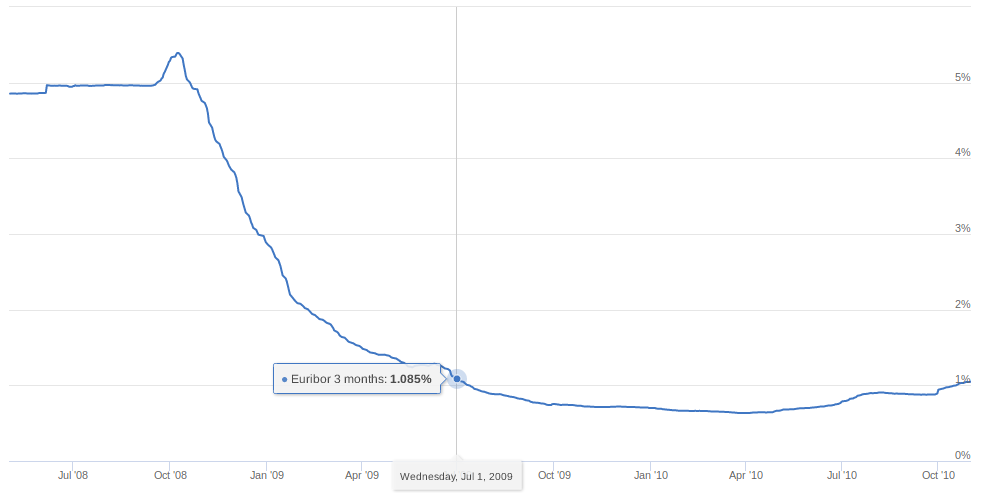

Нижеуказанный график позволяет понять распределение звонков по времени. Большинство звонков были сделаны в период с мая по октябрь  2008 года, когда ставка Euribor составяла около 5%.

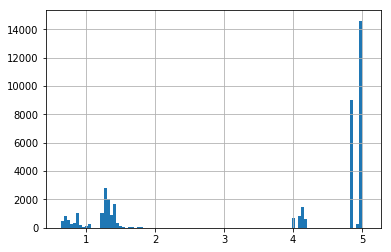

In [342]:
# The majority of calls were made from may to october 2008, when the euribor rate was around 5 %

df.euribor3m.hist(bins=100)

Экономика Португалии значительно пострадала от экономического кризиса 2007-2008 годов, 
вследствие чего социально-экономические показатели резко упали.  Уровень безработицы рос, как показывает характеристика "nr.employment".

Два массива данных показывают разницу между числом занятых лиц (в тысячах, по оси Х):

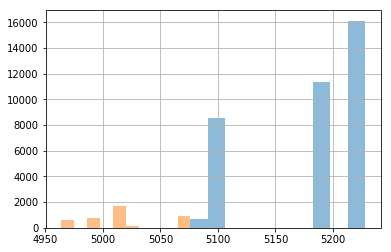

In [343]:
# Blue -- high euribor, prior to July 1, 2009
# Orange -- low euribor, after July 1, 2009

df[df['euribor3m'] > 1.1]['nr.employed'].hist(alpha=0.5)
df[df['euribor3m'] < 1.1]['nr.employed'].hist(alpha=0.5)



Это предположение подтверждается официальной государственной статистикой:

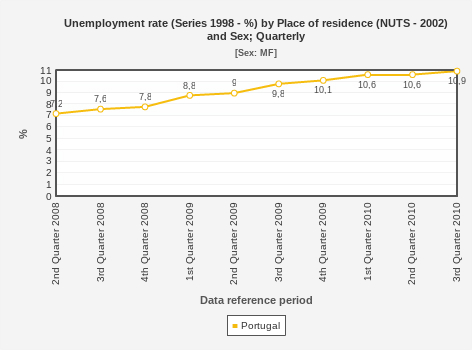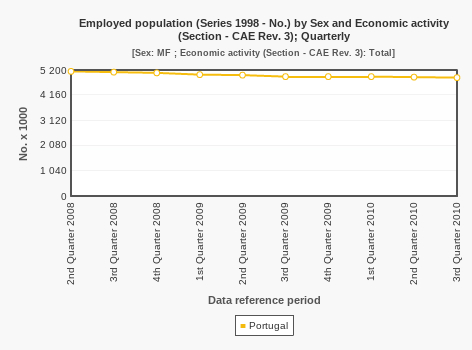



Опираясь на этот контекст, мы могли бы интерпретировать социально-экономические характеристики как относящиеся к острой или умеренно острой фазе кризиса. В качестве ориентира используется дата 1 июля 2009 года, когда ставка Euribor составляла около 1,1 %. Все звонки до этой даты считаются "звонками в период умеренно острого кризиса", а все звонки после -- "звонками в период острого кризиса".

Добавляем в датасет колонку "crisis" на основании показателя межбанковской процентной ставки 'Euribor':\
0 -- умеренно острая стадия кризиса\
1 -- острая стадия кризиса.

In [344]:
# Add 'crisis' column based on euribor attribute. '0' means 'no crisis', '1' means 'crisis' 

conditions = [
    df['euribor3m'] > 1.1,
    df['euribor3m'] < 1.1
]
choices = [0, 1]
df['crisis'] = np.select(conditions, choices)

Удаляем остальные социо-экономические характеристики из датасета.

In [345]:
# Drop other socio-economic attributes as no longer needed

soc_econ_attrs = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed']

df = df.drop(labels=soc_econ_attrs, axis=1) 

In [346]:
# copy original un-ohe-ed dataframe
df_unproc = df.copy()

### 3) Обработка данных <a class='anchor' id='chapter3'></a>



Применяем one-hot-кодирование для обработки датасета методами машинного обучения.

In [347]:
# Get dummy values

categorical_columns_dummy = []
for col in df.columns:
    if df[col].dtype == 'O':
        categorical_columns_dummy.append(col)

for x in categorical_columns_dummy:
    df_dum = pd.get_dummies(df[x], prefix=x)
    df= pd.concat([df, df_dum], axis=1)
df = df.drop(columns=categorical_columns_dummy, axis=1)

# Drop y_no column
df = df.drop(['y_no'], axis=1)


In [348]:
df_ohe = df
df.columns

Index(['age', 'campaign', 'pdays', 'previous', 'crisis', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure',
       'poutcome_nonexistent', 'p

Делим датасет на тренировочный и тестовый.

In [349]:
from sklearn.model_selection import train_test_split

X = df.drop('y_yes', axis=1)
y = df['y_yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)


Воспользуемся стохастическим вложением соседей с t-распределением (t-SNE) для визуализации датасета в двухмерном пространстве. Есть ли в данных какие-то паттерны, которые можно обнаружить с использованием машинного обучения?

Нормализуем данные.

In [350]:
# Normalize data for T-SNE

cols = X.columns

np_scaled = MinMaxScaler().fit_transform(X)
df_tsne = pd.DataFrame(np_scaled, columns = cols)

In [351]:
# T-SNE model 

t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(df_tsne.values)
t1 = time.time()
print(f"T-SNE took {t1 - t0}-s to run")



T-SNE took 1780.3753187656403-s to run


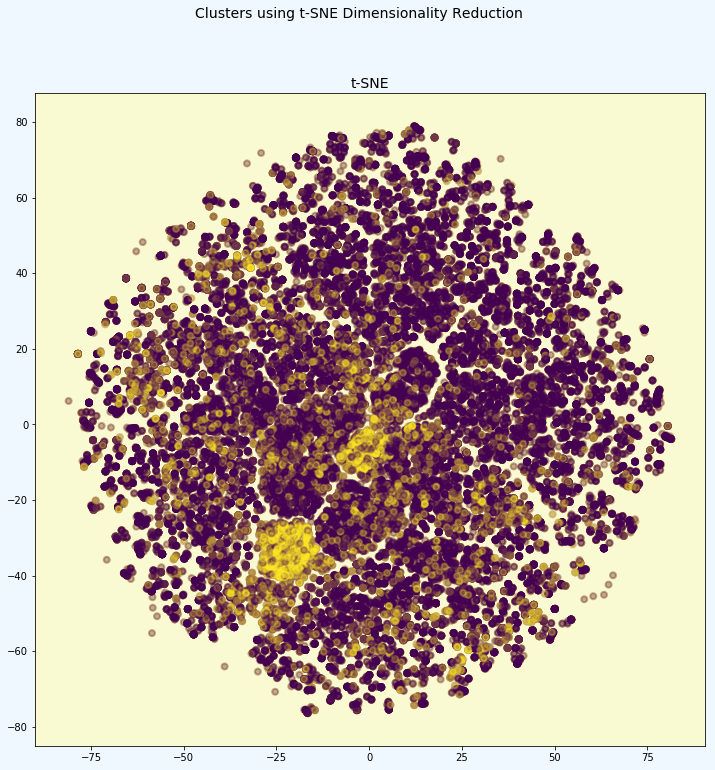

In [352]:
# Plot T-SNE
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(12,12))

# labels = ['No to deposit', 'Yes to deposit']
f.suptitle('Clusters using t-SNE Dimensionality Reduction', fontsize=14)


sienna_patch = mpatches.Patch(color='sienna', label='No to deposit')
seagreen_patch = mpatches.Patch(color='seagreen', label='Yes to deposit')


# t-SNE scatter plot
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(df.y_yes == 0), label='No to deposit', linewidths=2, alpha=0.3)
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(df.y_yes == 1), label='Yes to deposit', linewidths=2, alpha=0.3)
ax.set_title('t-SNE', fontsize=14)
ax.grid(False)
ax.set_facecolor('lightgoldenrodyellow')
f.set_facecolor('aliceblue')

### 4) Построение модели <a class='anchor' id='chapter4'></a>

Построим модель на основе алгоритма машинного обучения 'Random Forest Classifier' для нахождения клиентов, которые одобрят условия срочного вклада.

In [353]:
# K-Fold cross-validation
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X_train, y_train):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X_train.iloc[train_index], X_train.iloc[test_index]
    original_ytrain, original_ytest = y_train.iloc[train_index], y_train.iloc[test_index]

Train: [ 5955  5960  5962 ... 30704 30705 30706] Test: [   0    1    2 ... 6163 6164 6165]
Train: [    0     1     2 ... 30704 30705 30706] Test: [ 5955  5960  5962 ... 12509 12513 12519]
Train: [    0     1     2 ... 30704 30705 30706] Test: [12252 12253 12254 ... 18628 18630 18631]
Train: [    0     1     2 ... 30704 30705 30706] Test: [18398 18400 18401 ... 24585 24586 24587]
Train: [    0     1     2 ... 24585 24586 24587] Test: [24394 24400 24401 ... 30704 30705 30706]


Найдем оптимальные параметры для Random Forest Classifier.

In [354]:
# Find best parameters for Random Forest Classifer with GridSearch

rfc = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [50, 200, 500, 1000, 3000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,8],
    'min_samples_split': [2,4,6]
}

CV_rfc = GridSearchCV(rfc, param_grid=param_grid, verbose=10, n_jobs=-1, cv=4, scoring='f1')
CV_rfc.fit(original_Xtrain, original_ytrain)



Fitting 4 folds for each of 90 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 25

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 200, 500, 1000, 3000]},
             scoring='f1', verbose=10)

In [355]:
best_rfc_params = CV_rfc.best_params_
best_rfc = CV_rfc.best_estimator_

Обучение модели происходит на тренировочном датасете с использованием кросс-валидации и алгоритма SMOTE. 

В нашем случае датасет является несбалансированном, поскольку только 11.3% клиентов согласились на предлагаемый банком срочный вклад. Данное условие следует учитывать при построении модели и выборе метрик во избежание смещения модели в сторону "True Negative"s. Так если модель предскажет, что все клиенты откажутся от срочного вклада, точность данной модели составит 88.7% - правильно предсказанные случаи "True Negative". Однако с практической точки зрения такая модель окажется бесполезной. 

В данной работе для учета дисбаланса данных предлагаются 2 меры. Во-первых, используются метрики, учитывающие дисбаланс данных: оценка F1, AUC (Area Under Curve) показатель, кривая Precision-Recall. Во-вторых, для обучения модели используется алгоритм SMOTE, создающий на основе имеющихся данных меньшего по размеру класса искусственные данные, с помощью которых и обучается модель.   
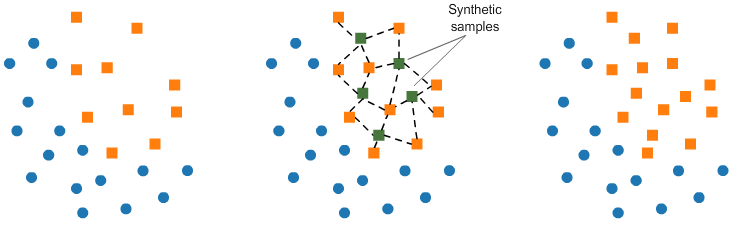


In [356]:
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

for train, test in tqdm(sss.split(original_Xtrain, original_ytrain)):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), best_rfc) 
    # SMOTE happens during cross-validation and not before
    model = pipeline.fit(original_Xtrain.iloc[train], original_ytrain.iloc[train])
    prediction = model.predict(original_Xtrain.iloc[test])
    
    precision_lst.append(precision_score(original_ytrain.iloc[test], prediction))
    recall_lst.append(recall_score(original_ytrain.iloc[test], prediction))
    f1_lst.append(f1_score(original_ytrain.iloc[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain.iloc[test], prediction))

5it [00:20,  4.01s/it]


Усреднённые значения метрик тренировочного датасета.

In [357]:
print(f'Mean for auc values is {statistics.mean(auc_lst)}')
print(f'Mean for f1-score values is {statistics.mean(f1_lst)}')
print(f'Mean for recall values is {statistics.mean(recall_lst)}')
print(f'Mean for precision values is {statistics.mean(precision_lst)}')


Mean for auc values is 0.714959169098468
Mean for f1-score values is 0.45860637828061274
Mean for recall values is 0.5288808664259927
Mean for precision values is 0.4056442801388925


Посмотрим, какие характеристики в наибольшей степени повлияли на модель.

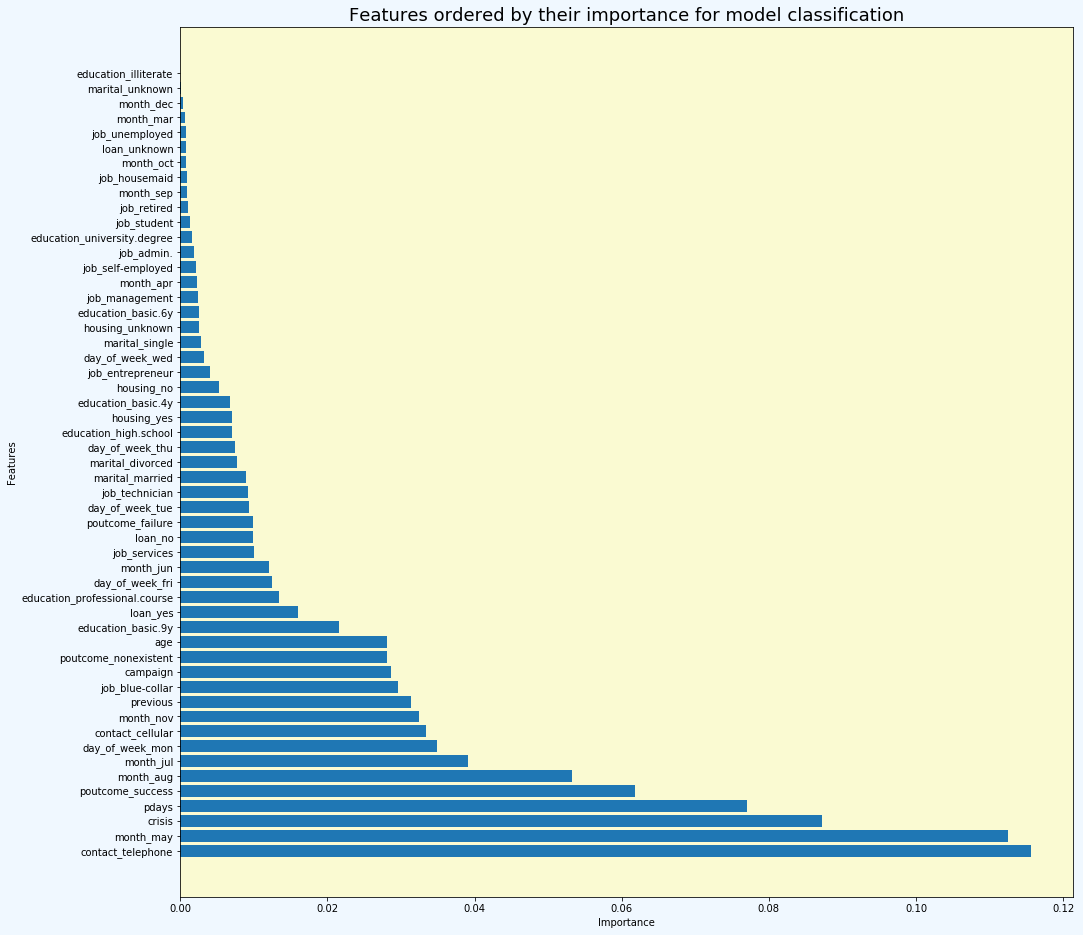

In [358]:
# Get importance of fatures values from model
df_feature_importance = pd.DataFrame(best_rfc.feature_importances_, index=X.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)

# Plot importance of features bar 
f, ax = plt.subplots(1,1, figsize = (16,16))
ax.barh(df_feature_importance.index, df_feature_importance['feature importance'])
ax.set_title('Features ordered by their importance for model classification', fontsize=18)
ax.set_facecolor('lightgoldenrodyellow')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
f.set_facecolor('aliceblue')

Применяем полученную модель на тестовом датасете. 

In [359]:
y_pred = best_rfc.predict(X_test)
print(f'F1-score for test dataset is {f1_score(y_test, y_pred)}')


F1-score for test dataset is 0.4725274725274725


Построим график кривой ROC

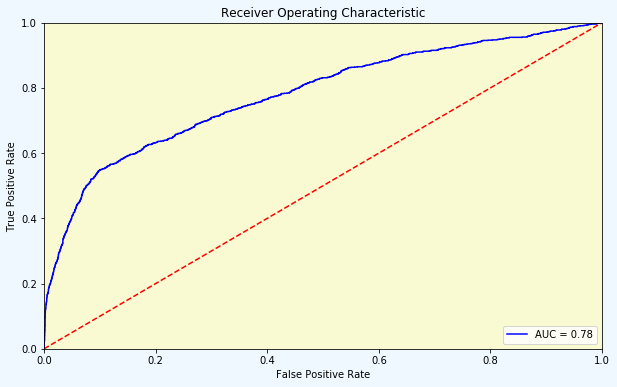

In [360]:
# Calculate the fpr and tpr for all thresholds of the classification
probs = best_rfc.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

f, ax = plt.subplots(figsize=(10,6))
ax.set_title('Receiver Operating Characteristic')
ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_facecolor('lightgoldenrodyellow')
f.set_facecolor('aliceblue')
plt.show()

Построим график кривой Precision-Recall.

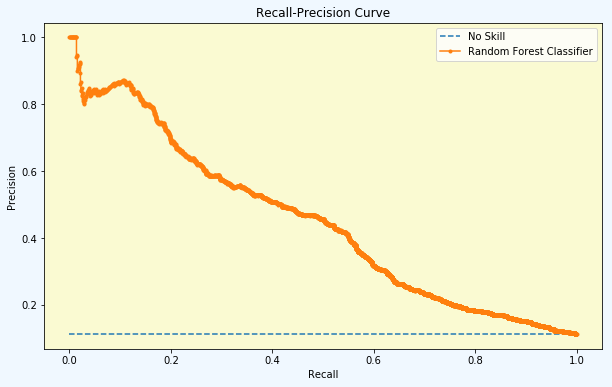

In [361]:
# Predict probabilities
lr_probs = best_rfc.predict_proba(X_test)
# Keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# Predict class values
yhat = best_rfc.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

no_skill = len(y_test[y_test==1]) / len(y_test)

# Plot the precision-recall curves
f, ax = plt.subplots(figsize=(10,6))
ax.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax.plot(lr_recall, lr_precision, marker='.', label='Random Forest Classifier')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Recall-Precision Curve')
ax.set_facecolor('lightgoldenrodyellow')
f.set_facecolor('aliceblue')
plt.legend()
plt.show()

### 5) Исследовательский анализ данных <a class='anchor' id='chapter5'></a>

Добавим в датасет колонку со значениями, показывающими вероятность того, что клиент согласится на срочный вклад.

In [362]:
df_ohe['predicted_probability'] = best_rfc.predict_proba(df_ohe.drop('y_yes', axis=1))[:, 1]

In [363]:
df_ohe.head()

,age,campaign,pdays,previous,crisis,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_yes,predicted_probability
0,56.00000,1.00000,999.00000,0.00000,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0.19830
1,57.00000,1.00000,999.00000,0.00000,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.18596
2,37.00000,1.00000,999.00000,0.00000,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.17632
3,40.00000,1.00000,999.00000,0.00000,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.19430
4,56.00000,1.00000,999.00000,0.00000,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.15616


Построим 'Confusion matrix' для тестового датасета.

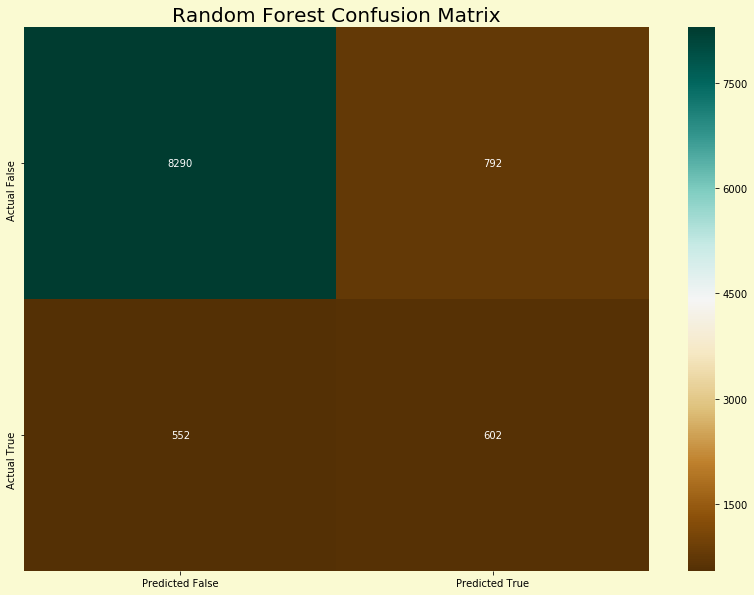

In [364]:
cf = confusion_matrix(y_test, y_pred)


fig, ax = plt.subplots(1,1, figsize=(14,10))
sns.heatmap(cf, annot = True,  cmap = plt.cm.BrBG, fmt='d', 
            xticklabels=['Predicted False', 'Predicted True'],
           yticklabels=['Actual False', 'Actual True'])
ax.set_title("Random Forest Confusion Matrix", fontsize=20)

fig.set_facecolor('lightgoldenrodyellow')

Построим график распределения вероятности того, что клиент согласится на срочный вклад.

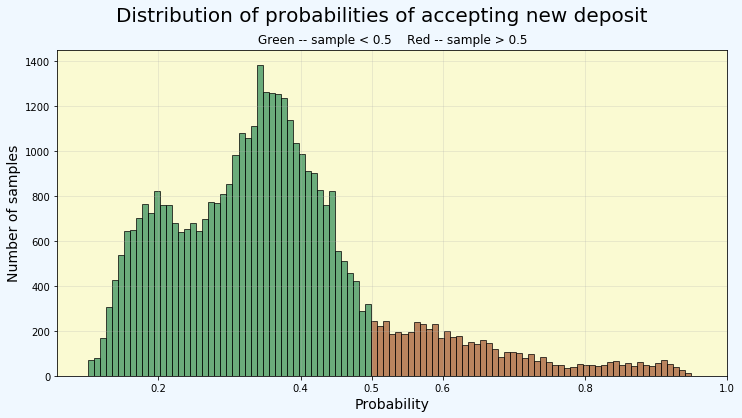

In [365]:
# Blue

fig = plt.figure(figsize=(12,6), facecolor='aliceblue')
ax = df_ohe.predicted_probability.hist(bins=100, color='sienna', edgecolor='black', linewidth=1, alpha=0.7)
for patch in ax.patches[:47]:
    patch.set_facecolor('seagreen') 

ax.set_title('Green -- sample < 0.5' + '    ' + 'Red -- sample > 0.5', fontsize=12)
ax.set_xlabel('Probability', fontsize=14)
ax.set_ylabel('Number of samples', fontsize=14)
ax.set_facecolor('lightgoldenrodyellow')
ax.set_xticks([0.2,0.4,0.5,0.6,0.8,1.0])
fig.suptitle('Distribution of probabilities of accepting new deposit', fontsize=20)
ax.grid(alpha=0.3)

plt.show()

Сравним насколько похожи 2 распределения по возрастному признаку: для клиентов, согласившихся на срочный вклад и клиентов, для которых модель показала вероятность согласия более 0.5.

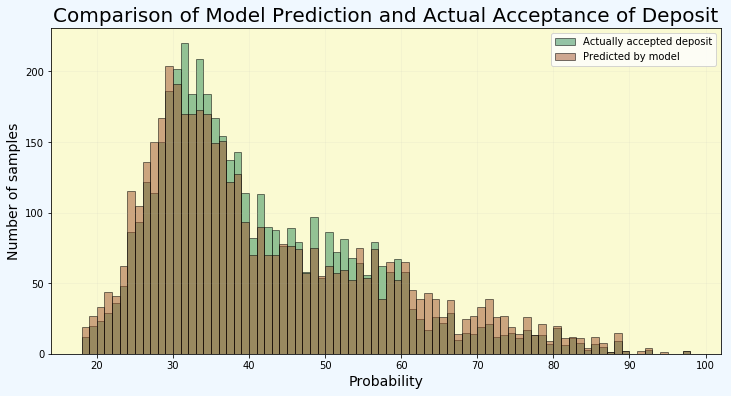

In [366]:
# predicted distribution is pretty much the same

bins_num = int(df_ohe.age.max()-df_ohe.age.min())

fig = plt.figure(figsize=(12,6), facecolor='gainsboro')

ax = df_ohe[df_ohe.y_yes == 1].age.hist(bins=bins_num, color='seagreen', 
                                        edgecolor='black', linewidth=1, alpha=0.5, 
                                        label='Actually accepted deposit')
ax = df_ohe[df_ohe.predicted_probability > 0.5].sample(len(df_ohe[df_ohe.y_yes == 1])).age.hist(bins=bins_num, 
                                                                                           color='sienna', 
                                                                                           edgecolor='black', 
                                                                                           linewidth=1, 
                                                                                           alpha=0.5,
                                                                                           label='Predicted by model')

ax.set_title('Comparison of Model Prediction and Actual Acceptance of Deposit', fontsize=20)
ax.set_xlabel("Clients' age", fontsize=14)
ax.set_ylabel('Number of samples', fontsize=14)
ax.grid(alpha=0.1)
ax.set_facecolor('lightgoldenrodyellow')
fig.set_facecolor('aliceblue')
plt.legend()
plt.show()



Выделим из датасета, только тех клиентов, чья вероятность согласия на срочный вклад составляет более 0.5.

In [367]:
# Only samples with model probability higher than 0.5 
yes_predicted_df = df_ohe[df_ohe['predicted_probability'] > 0.5]
len(yes_predicted_df)

5789

Разобъем клиентов на две группы: 
* группа клиентов с вероятностью согласия на срочный вклад менее 0.5 
* группа клиентов с вероятностью согласия более 0.5

Для каждой группы построим гистограмму, которая показывает согласились ли клиенты данной группы на срочный вклад на самом деле.

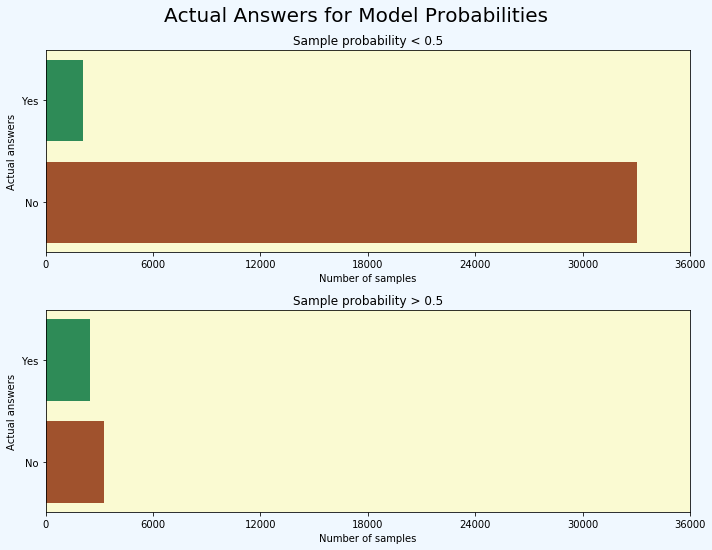

In [368]:
# Compare prob > 0.5, prob < 0.5

x1 = df_ohe[df_ohe['predicted_probability'] < 0.5].y_yes.value_counts().values
y1 = ['No', 'Yes']
x2 = yes_predicted_df.y_yes.value_counts().values
y2 = ['No', 'Yes']

fig, ax = plt.subplots(2,1, figsize=(10,8))

fig.set_facecolor('gainsboro')
colors = {'Yes':'seagreen', 'No':'sienna'}

ax[0].barh(y1, x1, color=[colors[t] for t in y1])
ax[1].barh(y2, x2, color=[colors[t] for t in y2])

ax[0].set_yticks([0,1])
ax[1].set_yticks([0,1])
ax[0].set_xticks([i for i in range(0, 36001, 6000)])
ax[1].set_xticks([i for i in range(0, 36001, 6000)])

ax[0].set_title('Sample probability < 0.5', fontsize=12)
ax[1].set_title('Sample probability > 0.5', fontsize=12)

ax[0].set_xlabel('Number of samples')
ax[1].set_xlabel('Number of samples')
ax[0].set_ylabel('Actual answers')
ax[1].set_ylabel('Actual answers')

ax[0].set_facecolor('lightgoldenrodyellow')
ax[1].set_facecolor('lightgoldenrodyellow')
fig.set_facecolor('aliceblue')

fig.suptitle('Actual Answers for Model Probabilities', fontsize=20)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust()
plt.show()


График показывает, что модель достаточно хорошо классифицирует 'True Negatives', то есть клиентов, которые  откажутся от срочного вклада и которым была присвоена вероятность менее 0.5.

Также несмотря на несбалансированность датасета, модель оказалась способна найти достаточно большое количество 'True Positives', то есть клиентов, которые согласятся на срочный вклад и которым была присвоена вероятность более 0.5.

Теперь рассмотрим разбиение по возрасту на три группы: 18-30 лет, 30-60 лет и 60+ лет. Также добавим разбиение по профессии внутри каждой из групп. Данное разбиение поможет выявить группы клиентов, которые с большей вероятностью отвечают согласием на предложенный банком срочный вклад.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


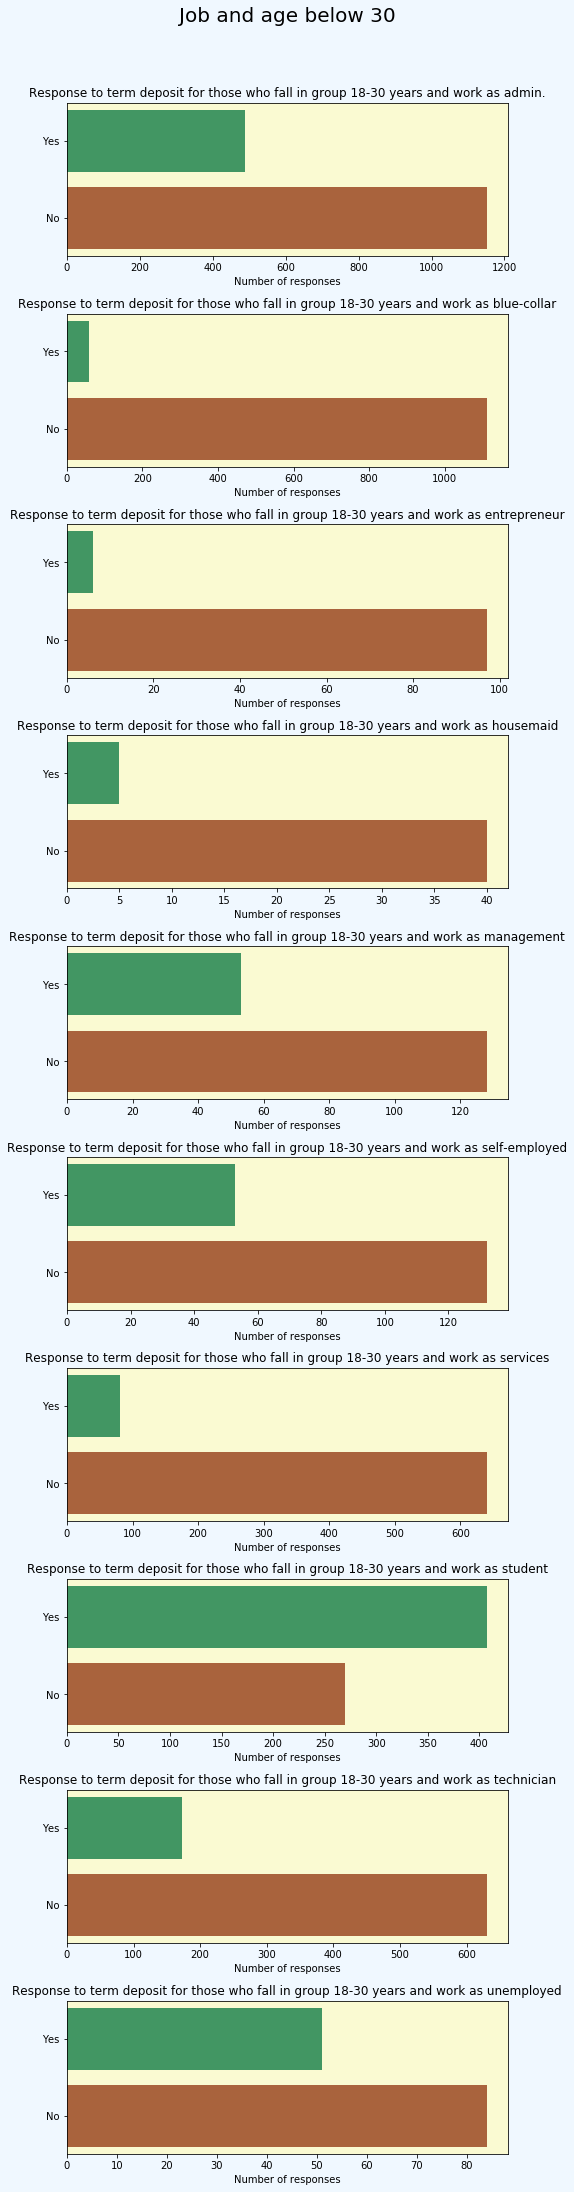

In [369]:
# 18-30
job_cols = ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management',  'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed']

fig, axes = plt.subplots(10,1, figsize = (8, 32))

count = 0
for ax in axes.flat:
    j_no= df_ohe[(df_ohe['predicted_probability'] < 0.5) & (df_ohe['age'] < 30)][job_cols[count]].value_counts(sort=False)
    j_yes = yes_predicted_df[(df_ohe['age'] < 30)][job_cols[count]].value_counts(sort=False)
    
    # Make data for charts
    x_ax = ['No', 'Yes']
    try:
        y_ax1 = j_no.values[1]
    except IndexError:
        y_ax1 = 0
    
    try:
        y_ax2 = j_yes.values[1]
    except IndexError:
        y_ax2 = 0
    
    y_ax = []
    y_ax.append(y_ax1)
    y_ax.append(y_ax2)
    
        
    # Plot chart
    colors = {'Yes':'seagreen', 
              'No':'sienna'}
    ax.barh(x_ax, y_ax , alpha=0.9, color=[colors[t] for t in x_ax])
    
    # Tune settings
    ax.set_title(f'Response to term deposit for those who fall in group 18-30 years and work as {job_cols[count][4:]}')
    ax.set_xlabel('Number of responses')
    ax.set_facecolor('lightgoldenrodyellow')
    
    count+= 1

fig.suptitle('Job and age below 30', fontsize=20)
fig.set_facecolor('aliceblue')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust()
plt.show()


В данной возрастной группе лучшие показатели согласия у клиентов, являющихся студентами, а также работающих на административной должности.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


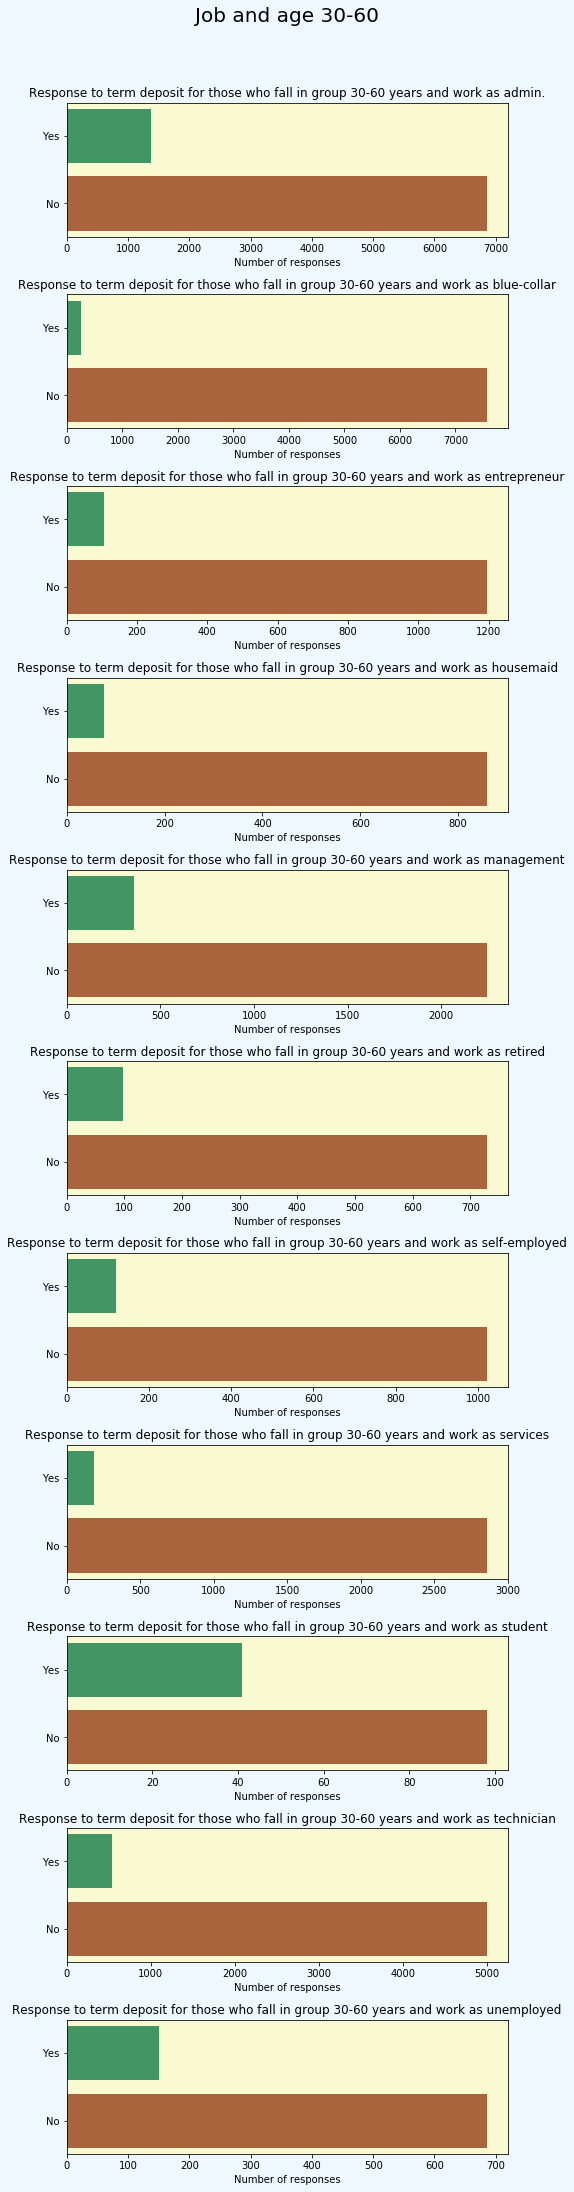

In [370]:
# 30-60

job_cols = ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management',  'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed']

fig, axes = plt.subplots(11,1, figsize = (8, 32))

count = 0
for ax in axes.flat:
    j_no= df_ohe[(df_ohe['predicted_probability'] < 0.5) & ((df_ohe['age'] < 60) & (df_ohe['age'] > 30))][job_cols[count]].value_counts(sort=False)
    j_yes = yes_predicted_df[((df_ohe['age'] < 60) & (df_ohe['age'] > 30))][job_cols[count]].value_counts(sort=False)
    
    # Make data for charts
    x_ax = ['No', 'Yes']
    try:
        y_ax1 = j_no.values[1]
    except IndexError:
        y_ax1 = 0
    
    try:
        y_ax2 = j_yes.values[1]
    except IndexError:
        y_ax2 = 0
    
    y_ax = []
    y_ax.append(y_ax1)
    y_ax.append(y_ax2)
    
        
    # Plot chart
    colors = {'Yes':'seagreen', 
              'No':'sienna'}
    ax.barh(x_ax, y_ax , alpha=0.9, color=[colors[t] for t in x_ax])
    
    # Tune settings
    ax.set_title(f'Response to term deposit for those who fall in group 30-60 years and work as {job_cols[count][4:]}')
    ax.set_xlabel('Number of responses')
    ax.set_facecolor('lightgoldenrodyellow')
    
    count+= 1

fig.suptitle('Job and age 30-60', fontsize=20)
fig.set_facecolor('aliceblue')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust()
plt.show()

В данной возрастной группе лучшие показатели согласия у клиентов, являющихся студентами, безработными, а также работающих в сфере менеджмента или на административной должности.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


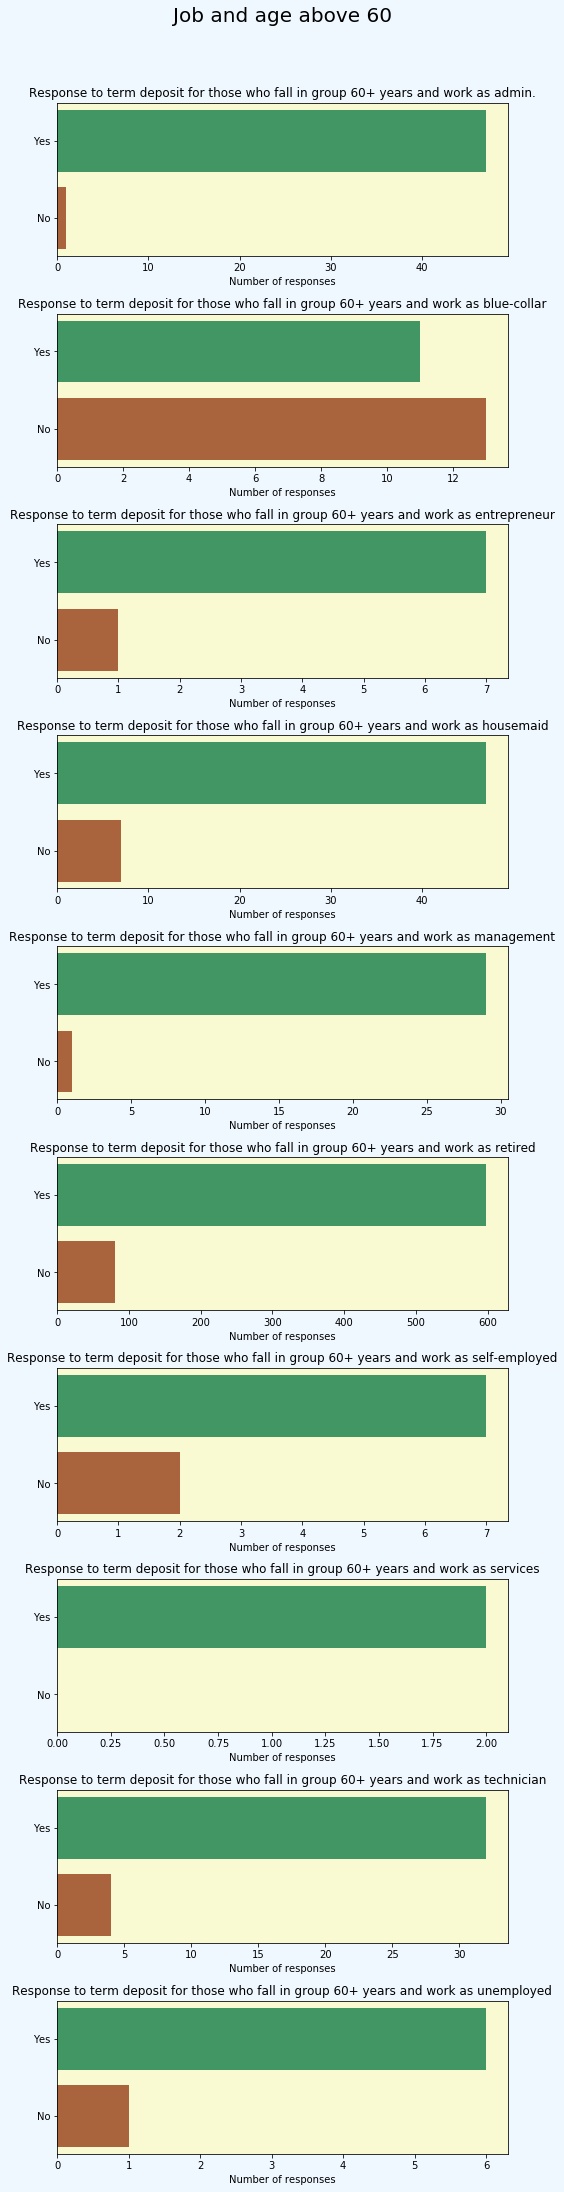

In [371]:
# 60+

job_cols = ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management',  'job_retired', 'job_self-employed', 'job_services',
            'job_technician', 'job_unemployed']

fig, axes = plt.subplots(10,1, figsize = (8, 32))

count = 0
for ax in axes.flat:
    j_no= df_ohe[(df_ohe['predicted_probability'] < 0.5) & (df_ohe['age'] > 60)][job_cols[count]].value_counts(sort=False)
    j_yes = yes_predicted_df[(df_ohe['age'] > 60)][job_cols[count]].value_counts(sort=False)
    
    # Make data for charts
    x_ax = ['No', 'Yes']
    try:
        y_ax1 = j_no.values[1]
    except IndexError:
        y_ax1 = 0
    
    try:
        y_ax2 = j_yes.values[1]
    except IndexError:
        y_ax2 = 0
    
    y_ax = []
    y_ax.append(y_ax1)
    y_ax.append(y_ax2)
    
        
    # Plot chart
    colors = {'Yes':'seagreen', 
              'No':'sienna'}
    ax.barh(x_ax, y_ax , alpha=0.9, color=[colors[t] for t in x_ax])
    
    # Tune settings
    ax.set_title(f'Response to term deposit for those who fall in group 60+ years and work as {job_cols[count][4:]}')
    ax.set_xlabel('Number of responses')
    ax.set_facecolor('lightgoldenrodyellow')
    
    count+= 1

fig.suptitle('Job and age above 60', fontsize=20)
fig.set_facecolor('aliceblue')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust()
plt.show()

В данной возрастной группе лучшие показатели согласия у клиентов, вышедших на пенсию, работающих на административной должности и в сфере менеджмента.

Проведём разбиение клиентов по характеристике "образование".

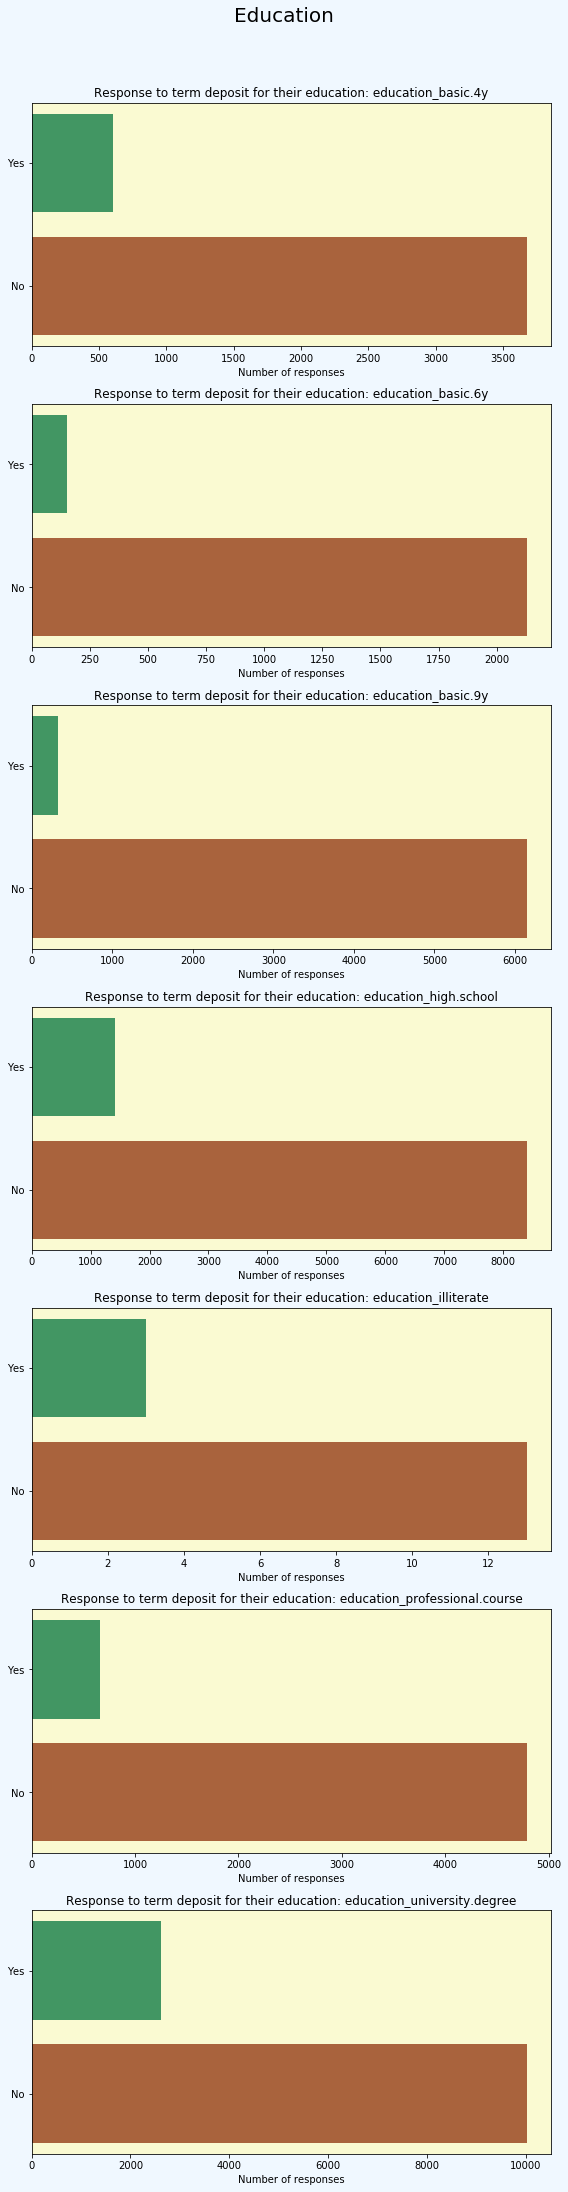

In [372]:
educat_cols= ['education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree']

fig, axes = plt.subplots(len(educat_cols),1, figsize = (8, 32))

count = 0
for ax in axes.flat:
    
    # Using sample(df) to compare equal shares
    j_no= df_ohe[df_ohe['predicted_probability'] < 0.5][educat_cols[count]].value_counts(sort=False)
    j_yes = yes_predicted_df[educat_cols[count]].value_counts(sort=False)
    
    # Make data for charts
    x_ax = ['No', 'Yes']
  # Conditions to avoid situations when value_counts() doesn't return value, because it's absent in the dataframe
    if len(j_no.values) == 1 & len(j_yes.values) == 1:
        continue 
    elif len(j_no.values) == 1:
        y_ax = 0 ,j_yes.values[1]
    elif len(j_yes.values) == 1:
        y_ax = j_no.values[1], 0  
    else:
        y_ax = j_no.values[1],j_yes.values[1]
    
    
        
    # Plot chart
    colors = {'Yes':'seagreen', 
              'No':'sienna'}
    ax.barh(x_ax, y_ax , alpha=0.9, color=[colors[t] for t in x_ax])
    
    # Tune settings
    ax.set_title(f'Response to term deposit for their education: {educat_cols[count]}')
    ax.set_xlabel('Number of responses')
    ax.set_facecolor('lightgoldenrodyellow')
    
    count+= 1

fig.suptitle('Education', fontsize=20)
fig.set_facecolor('aliceblue')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust()
plt.show()

Лучшие показатели согласия наблюдаются в группе клиентов, имеющих полное высшее образование, а также полное среднее образование.

К сожалению, модель не смогла обнаружить связь между согласием клиента на срочный вклад и наличием опыта взаимодействия с нашим банком.

График на основании данных оригинального датасета.

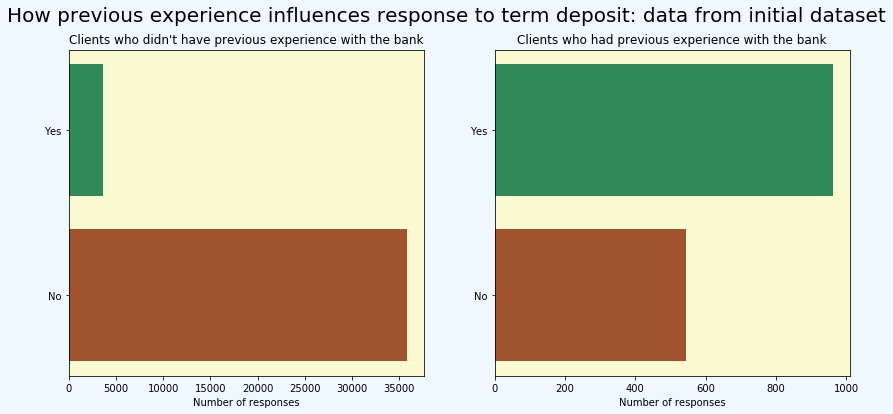

In [373]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1,2,1)
bx = fig.add_subplot(1,2,2)

absent_contact_no = df_ohe[(df_ohe['pdays'] == 999) & (df_ohe['y_yes'] == 0)].pdays
absent_contact_yes = df_ohe[(df_ohe['pdays'] == 999) & (df_ohe['y_yes'] == 1)].pdays

had_contact_yes = df_ohe[(df_ohe['pdays'] < 999) & (df_ohe['y_yes'] == 1)].pdays
had_contact_no = df_ohe[(df_ohe['pdays'] < 999) & (df_ohe['y_yes'] == 0)].pdays

# Plot chart
colors = {'Yes':'seagreen', 'No':'sienna'}
x_ax = ['No', 'Yes']
ax.barh(x_ax, [len(absent_contact_no), len(absent_contact_yes)], color=[colors[t] for t in x_ax])
bx.barh(x_ax, [len(had_contact_no), len(had_contact_yes)], color=[colors[t] for t in x_ax])

# Tune axes settings
ax.set_title("Clients who didn't have previous experience with the bank")
bx.set_title("Clients who had previous experience with the bank")
ax.set_xlabel('Number of responses')
bx.set_xlabel('Number of responses')
ax.set_facecolor('lightgoldenrodyellow')
bx.set_facecolor('lightgoldenrodyellow')

# Tune figure settings
fig.suptitle('How previous experience influences response to term deposit: data from original dataset', fontsize=20)
fig.set_facecolor('aliceblue')
fig.subplots_adjust()

plt.show()

График на основании вероятностей, полученных моделью.

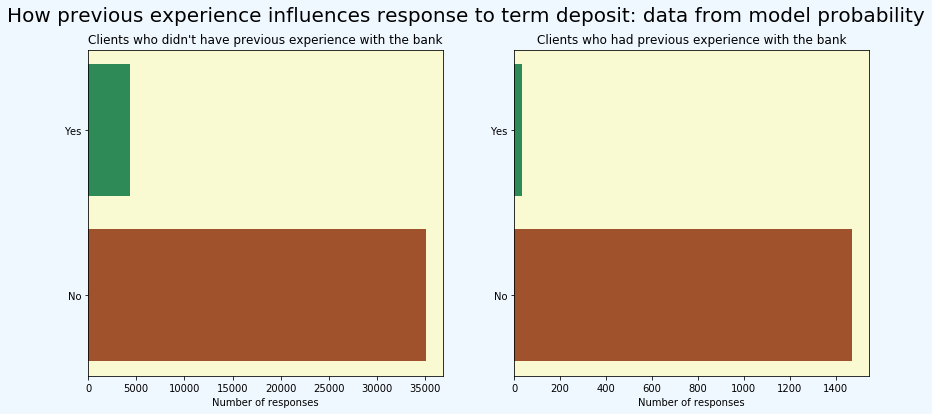

In [374]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1,2,1)
bx = fig.add_subplot(1,2,2)

absent_contact_no = df_ohe[(df_ohe['pdays'] == 999) & (df_ohe['predicted_probability'] < 0.5)].pdays
absent_contact_yes = df_ohe[(df_ohe['pdays'] == 999) & (df_ohe['predicted_probability'] > 0.5)].pdays

had_contact_yes = df_ohe[(df_ohe['pdays'] < 999) & (df_ohe['predicted_probability'] < 0.5)].pdays
had_contact_no = df_ohe[(df_ohe['pdays'] < 999) & (df_ohe['predicted_probability'] > 0.5)].pdays

# Plot chart
colors = {'Yes':'seagreen', 'No':'sienna'}
x_ax = ['No', 'Yes']
ax.barh(x_ax, [len(absent_contact_no), len(absent_contact_yes)], color=[colors[t] for t in x_ax])
bx.barh(x_ax, [len(had_contact_no), len(had_contact_yes)], color=[colors[t] for t in x_ax])

# Tune axes settings
ax.set_title("Clients who didn't have previous experience with the bank")
bx.set_title("Clients who had previous experience with the bank")
ax.set_xlabel('Number of responses')
bx.set_xlabel('Number of responses')
ax.set_facecolor('lightgoldenrodyellow')
bx.set_facecolor('lightgoldenrodyellow')

# Tune figure settings
fig.suptitle('How previous experience influences response to term deposit: data from model probability', fontsize=20)
fig.set_facecolor('aliceblue')
fig.subplots_adjust()

plt.show()

Влияет ли успех предыдущего взаимодействия с банком на согласие клиента на предложенный срочный вклад?

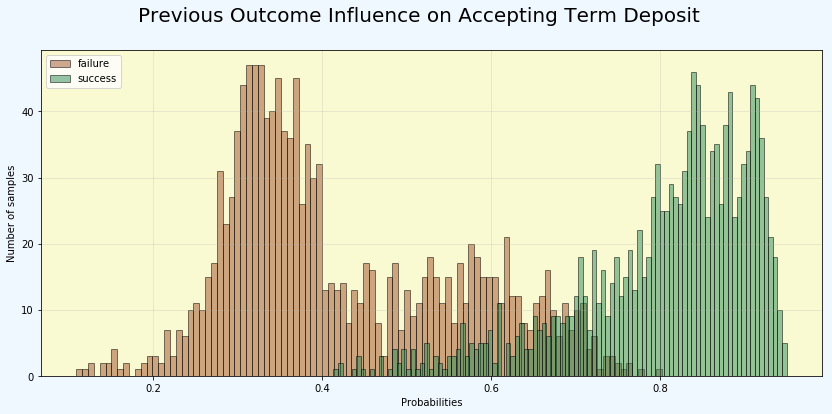

In [375]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1,1,1)
ax.set_facecolor('lightgoldenrodyellow')
ax.set_xlabel('Probabilities')
ax.set_ylabel('Number of samples')
ax.grid(alpha=0.3)

# Let's take samples from 'previous outcome failure' and 'previous outcome success'
success_and_yes = df_ohe[(df_ohe['poutcome_success'] == 1)]
# There are more 'previous outcome failure' samples in initial dataset, so we take sample
# size of equal amount
df_ohe[(df_ohe['poutcome_failure'] == 1)].sample(len(success_and_yes)).predicted_probability.hist(bins=100, 
                                                                                                  alpha=0.5, 
                                                                                                  label='failure', 
                                                                                                  color='sienna', 
                                                                                                  edgecolor='black')
success_and_yes.predicted_probability.hist(bins=100, 
                                           alpha=0.5, 
                                           label = 'success', 
                                           color='seagreen', 
                                           edgecolor='black')

plt.legend()
fig.suptitle('Previous Outcome Influence on Accepting Term Deposit', fontsize=20)
fig.set_facecolor('aliceblue')
fig.subplots_adjust()

# If previous outcome is successful clients are more likely to accept term deposit 

Да -- клиенты, уже пользовавшиеся услугами банка, скорее всего ответят согласием на предложенный срочный вклад.

Рассмотрим, как способ коммуникации с клиентом -- посредством мобильного или стационарного телефона -- влияет на согласие клиента на срочный вклад.

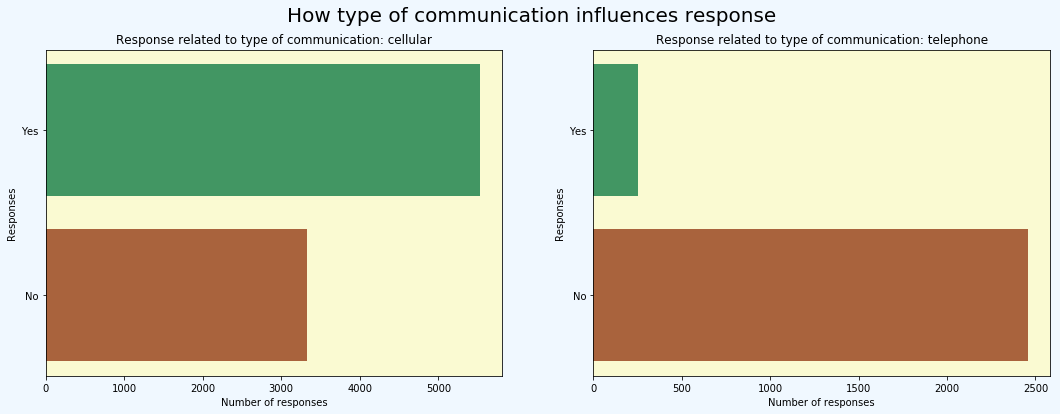

In [376]:
fig, axes = plt.subplots(1,2, figsize = (18, 6))

contact_type = ['contact_cellular', 'contact_telephone']

count = 0
for ax in axes.flat:
    j_yes = yes_predicted_df[contact_type[count]].value_counts(sort=False)
    j_no = df_ohe[(df_ohe['predicted_probability'] < 0.5)].sample(len(yes_predicted_df[contact_type[count]]))[contact_type[count]].value_counts(sort=False)
    
    x_ax = ['No', 'Yes']
    y_ax = j_no.values[1],j_yes.values[1]
    colors = {'No':'sienna', 'Yes':'seagreen'}
    ax.barh(x_ax, y_ax, alpha=0.9, color=[colors[t] for t in x_ax])
    
    
    # Tune settings
    ax.set_xlabel('Number of responses')
    ax.set_ylabel('Responses')
    ax.set_title(f'Response related to type of communication: {contact_type[count][8:]}')
    ax.set_facecolor('lightgoldenrodyellow')
    
    count += 1

    
# Tune figure settings
fig.suptitle('How type of communication influences response', fontsize=20)
fig.set_facecolor('aliceblue')
fig.subplots_adjust()
plt.show()
    
# But why?

В чем причина такой сильной корреляции между средством коммуникации и результатом взаимодействия? Может быть, по стационарному телефону происходит коммуникация с определённой возрастной группой? Посмотрим график распределения по возрасту для коммуникации посредством мобильного или стационарного телефона.

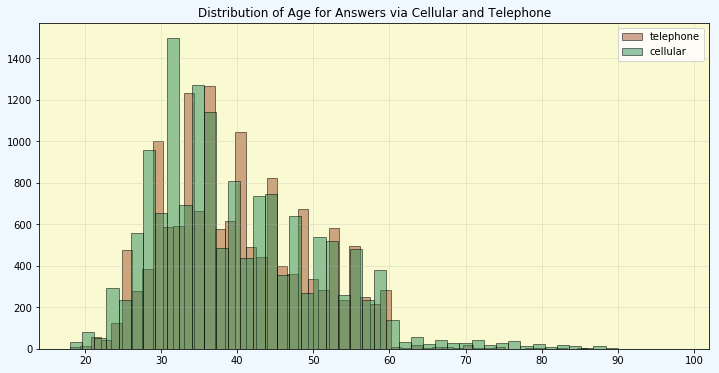

In [377]:
fig, ax = plt.subplots(figsize=(12,6))


df_ohe[df_ohe['contact_telephone'] == 1].age.hist(bins=50, 
                                           alpha=0.5, 
                                           label = 'telephone', 
                                           color='sienna', 
                                           edgecolor='black')
# sample() for equal sample size
df_ohe[df_ohe['contact_cellular'] == 1].sample(len(df_ohe[df_ohe['contact_telephone'] == 1])).age.hist(bins=50, 
                                           alpha=0.5, 
                                           label = 'cellular', 
                                           color='seagreen', 
                                           edgecolor='black')
plt.legend()
ax.set_title('Distribution of Age for Answers via Cellular and Telephone')
ax.set_facecolor('lightgoldenrodyellow')
ax.grid(alpha=0.3)
fig.set_facecolor('aliceblue')

# No, the distributions are pretty much the same

В целом, распределения похожи.

Возможно, использование мобильного телефона связано с уровнем образования клиента, что во многом определяет легкость адаптации человека к новым технологиям.

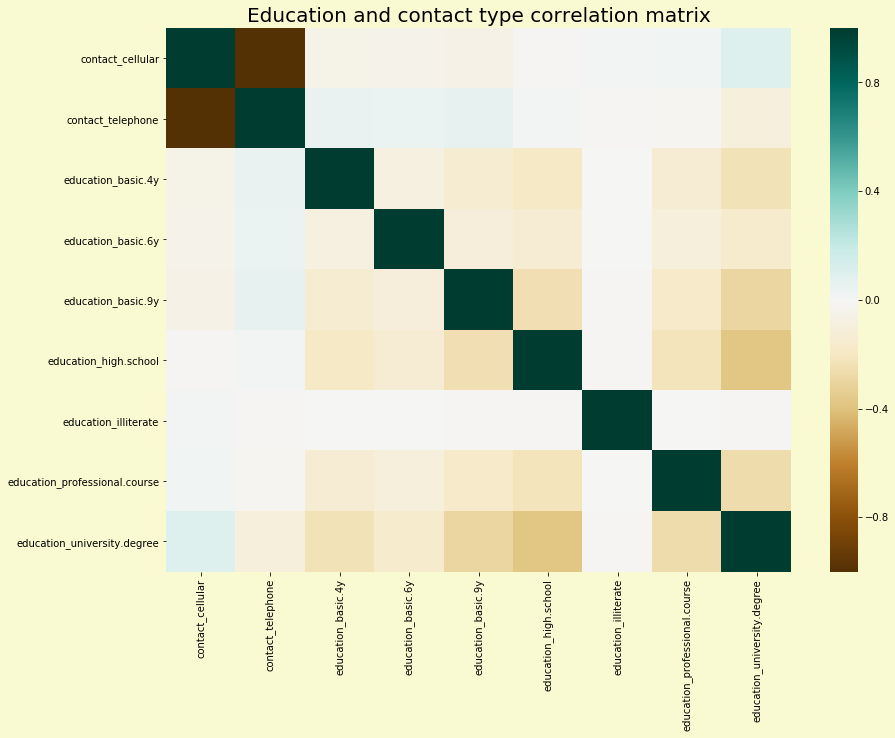

In [378]:
fig, ax = plt.subplots(1,1, figsize=(14,10))
sns.heatmap(df_ohe.loc[:, contact_type + educat_cols].corr(), cmap=plt.cm.BrBG, square=False)
ax.set_title("Education and contact type correlation matrix", fontsize=20)
fig.set_facecolor('lightgoldenrodyellow')

# Базовое образование == телефон
# Университетская степень == мобильный


Мы видим, что использование мобильного телефона имеет наиболее сильную корреляцию с группой клиентов, имеющих высшее образование. Учитывая, что клиенты данной группы с большой вероятностью отвечают согласием на предложенный срочный вклад, именно уровень образования, а не способ коммуникации является определяющим параметром.


### 6) Рекомендации <a class='anchor' id='chapter6'></a>

В результате анализа были выявлены характеристики, влияющие на согласие клиента открыть срочный вклад в банке. Такими характеристиками стали:

##### Род деятельности ('job'):
    * для группы клиентов младше 30 лет -- студенты и работающие на административной должности
    * для группы клиентов 30-60 лет -- работающие на административной должности
    * для группы клиентов старше 60 лет -- вышедшие на пенсию и работающие в качестве менеджеров

##### 2) Образование 
Лучшая доля согласия отмечается в группах клиентов с высшим и полным средним образованием

##### 3) Опыт взаимодействия с банком 
Даже негативный опыт взаимодействия с банком повышает шанс согласия клиента на предложенную услугу при следующем взаимодействии

##### 4) Способ контакта с клиентом 
Мобильный телефон более предпочтителен, чем стационарный телефон для коммуникации с клиентом



Таким образом, на основании представленных характеристик можно составить три портрета клиентов, которые с большей вероятностью согласятся открыть срочный вклад.

* Клиент в возрасте до 30 лет, студент
* Клиент в возрасте от 30 до 60 лет, работает на административной должности, имел опыт взаимодействия с данным банком, имеет высшее образование
* Клиент в возрасте от 60 лет, пенсионер, имел опыт взаимодействия с данным банком

Для каждой из данных категорий могут быть разработаны категоризированные предложения по услуге открытия срочного вклада, что должно повысить процент согласия для

# Посчитать сколько денег будет потрачено на обзвон всех клиентов и при обзвоне только клиентов по характеристикам
при цене звонка в 1$ например.

In [10]:
df[(df['job'] == 'retired') & (df['age'] > 60)].y.value_counts()

no     365
yes    313
Name: y, dtype: int64